In [1]:
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(platetools)))
suppressWarnings(suppressPackageStartupMessages(library(gridExtra)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(viridis)))
suppressWarnings(suppressPackageStartupMessages(library(argparse)))    
suppressWarnings(suppressPackageStartupMessages(library(patchwork)))

In [2]:
# generate a platemap plot for the meta data
# read in the platemap data
platemap_df_path <- "../../../data/Interstellar_plate2_platemap.csv"
platemap_df <- read.csv(platemap_df_path)
# if cell_type is blank, set it to "blank"
platemap_df$cell_type[platemap_df$cell_type == ""] <- ""
# if treatment is blank, set it to "blank"
platemap_df$inducer1[platemap_df$inducer1 == ""] <- ""
# replace the "" with ""
platemap_df$inducer2[platemap_df$inducer2 == ""] <- ""
# replace the "" with ""
platemap_df$inhibitor[platemap_df$inhibitor == ""] <- ""
# replace the "" with ""
platemap_df$inhibitor_concentration[platemap_df$inhibitor_concentration == 'NA'] <- ""
platemap_df$inhibitor_concentration[is.na(platemap_df$inhibitor_concentration)] <- ""
platemap_df$inducer2_concentration[is.na(platemap_df$inducer2_concentration)] <- ""
platemap_df$inducer2[is.na(platemap_df$inducer2)] <- ""
# replace the "" with ""
platemap_df$inducer1_concentration[platemap_df$inducer1_concentration == 'NA'] <- ""
platemap_df$inducer2_concentration[platemap_df$inducer2_concentration == 'NA'] <- ""
# replace NA with ""
platemap_df$inducer1_concentration[platemap_df$inducer1_concentration == 'NA'] <- ""

In [3]:

# define save path
platemap_path <- file.path("../figures/")
# make path if it doesn't exist
if (!dir.exists(platemap_path)){
    dir.create(platemap_path)
}

In [4]:
width <- 10
height <- 7
options(repr.plot.width = width, repr.plot.height = height)

In [5]:

# add inducer 1 to inducer 1 concentration
platemap_df$inducer1_conc <- paste(platemap_df$inducer1, platemap_df$inducer1_concentration, platemap_df$inducer1_concentration_unit, sep = " ")
platemap_df$inducer2_conc <- paste(platemap_df$inducer2, platemap_df$inducer2_concentration,platemap_df$inducer2_concentration_unit, sep = " ")
# add inducer1_conc to inducer2_conc if inducer2_conc is not blank
platemap_df$inducer_conc <- ifelse(
    platemap_df$inducer2_conc == " ",
    platemap_df$inducer1_conc, 
    paste(platemap_df$inducer1_conc, 
    platemap_df$inducer2_conc, 
    sep = " + "))

# add inhibitor to inhibitor concentration
platemap_df$inhibitor_conc <- paste(platemap_df$inhibitor, platemap_df$inhibitor_concentration, sep = " ")


In [6]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inducer1_conc[platemap_df$inducer1_conc == "media ctr  µg/ml"] <- "Media ctr  "
platemap_df$inducer1_conc[platemap_df$inducer1_conc == "media ctr  "] <- "Media ctr  "
platemap_df$inducer1_conc[platemap_df$inducer1_conc == "Media ctr  "] <- "Media"
platemap_df$inducer1_conc[platemap_df$inducer1_conc == '  '] <- "Blank"
platemap_df$cell_type[platemap_df$cell_type == ''] <- "Blank"
# replace 'flagellin 1.000 ' with 'flagellin 1.000 µg/ml
platemap_df$inducer1_conc[platemap_df$inducer1_conc == "Flagellin 1.000 "] <- "Flagellin 1.000 µg/ml"
# replace disulfiram 2.5µM µM with disulfiram 2.500 µM
platemap_df$inducer1_conc[platemap_df$inducer1_conc == "Disulfiram 2.5µM µM"] <- "Disulfiram 2.500 µM"
unique(platemap_df$inducer1_conc)
# redefine the values and order
platemap_df$inducer1_conc <- factor(
    platemap_df$inducer1_conc, 
    levels = c(
    'Blank',
    'Media',
    'DMSO 0.100 %',
    
    'LPS 0.010 µg/ml',
    'LPS 0.100 µg/ml',
    'LPS 1.000 µg/ml',
    'LPS 10.000 µg/ml',
    'LPS 100.000 µg/ml',
    'Flagellin 0.100 µg/ml',
    'Flagellin 1.000 µg/ml',
    'Disulfiram 0.100 µM',
    'Disulfiram 1.000 µM',
    'Disulfiram 2.500 µM',
    'H2O2 100.000 nM',
    'H2O2 100.000 µM',
    'Thapsigargin 1.000 µM',
    'Thapsigargin 10.000 µM',
    'Topotecan 5.000 nM',
    'Topotecan 10.000 nM',
    'Topotecan 20.000 nM'
    )
)

[1] "Blank"                  "LPS 0.010 µg/ml"        "LPS 0.100 µg/ml"       
 [4] "LPS 1.000 µg/ml"        "LPS 10.000 µg/ml"       "LPS 100.000 µg/ml"     
 [7] "Disulfiram 0.100 µM"    "Disulfiram 1.000 µM"    "Disulfiram 2.500 µM"   
[10] "H2O2 100.000 nM"        "H2O2 100.000 µM"        "Flagellin 0.100 µg/ml" 
[13] "Flagellin 1.000 µg/ml"  "Media"                  "DMSO 0.100 %"          
[16] "Thapsigargin 1.000 µM"  "Thapsigargin 10.000 µM" "Topotecan 5.000 nM"    
[19] "Topotecan 10.000 nM"    "Topotecan 20.000 nM"

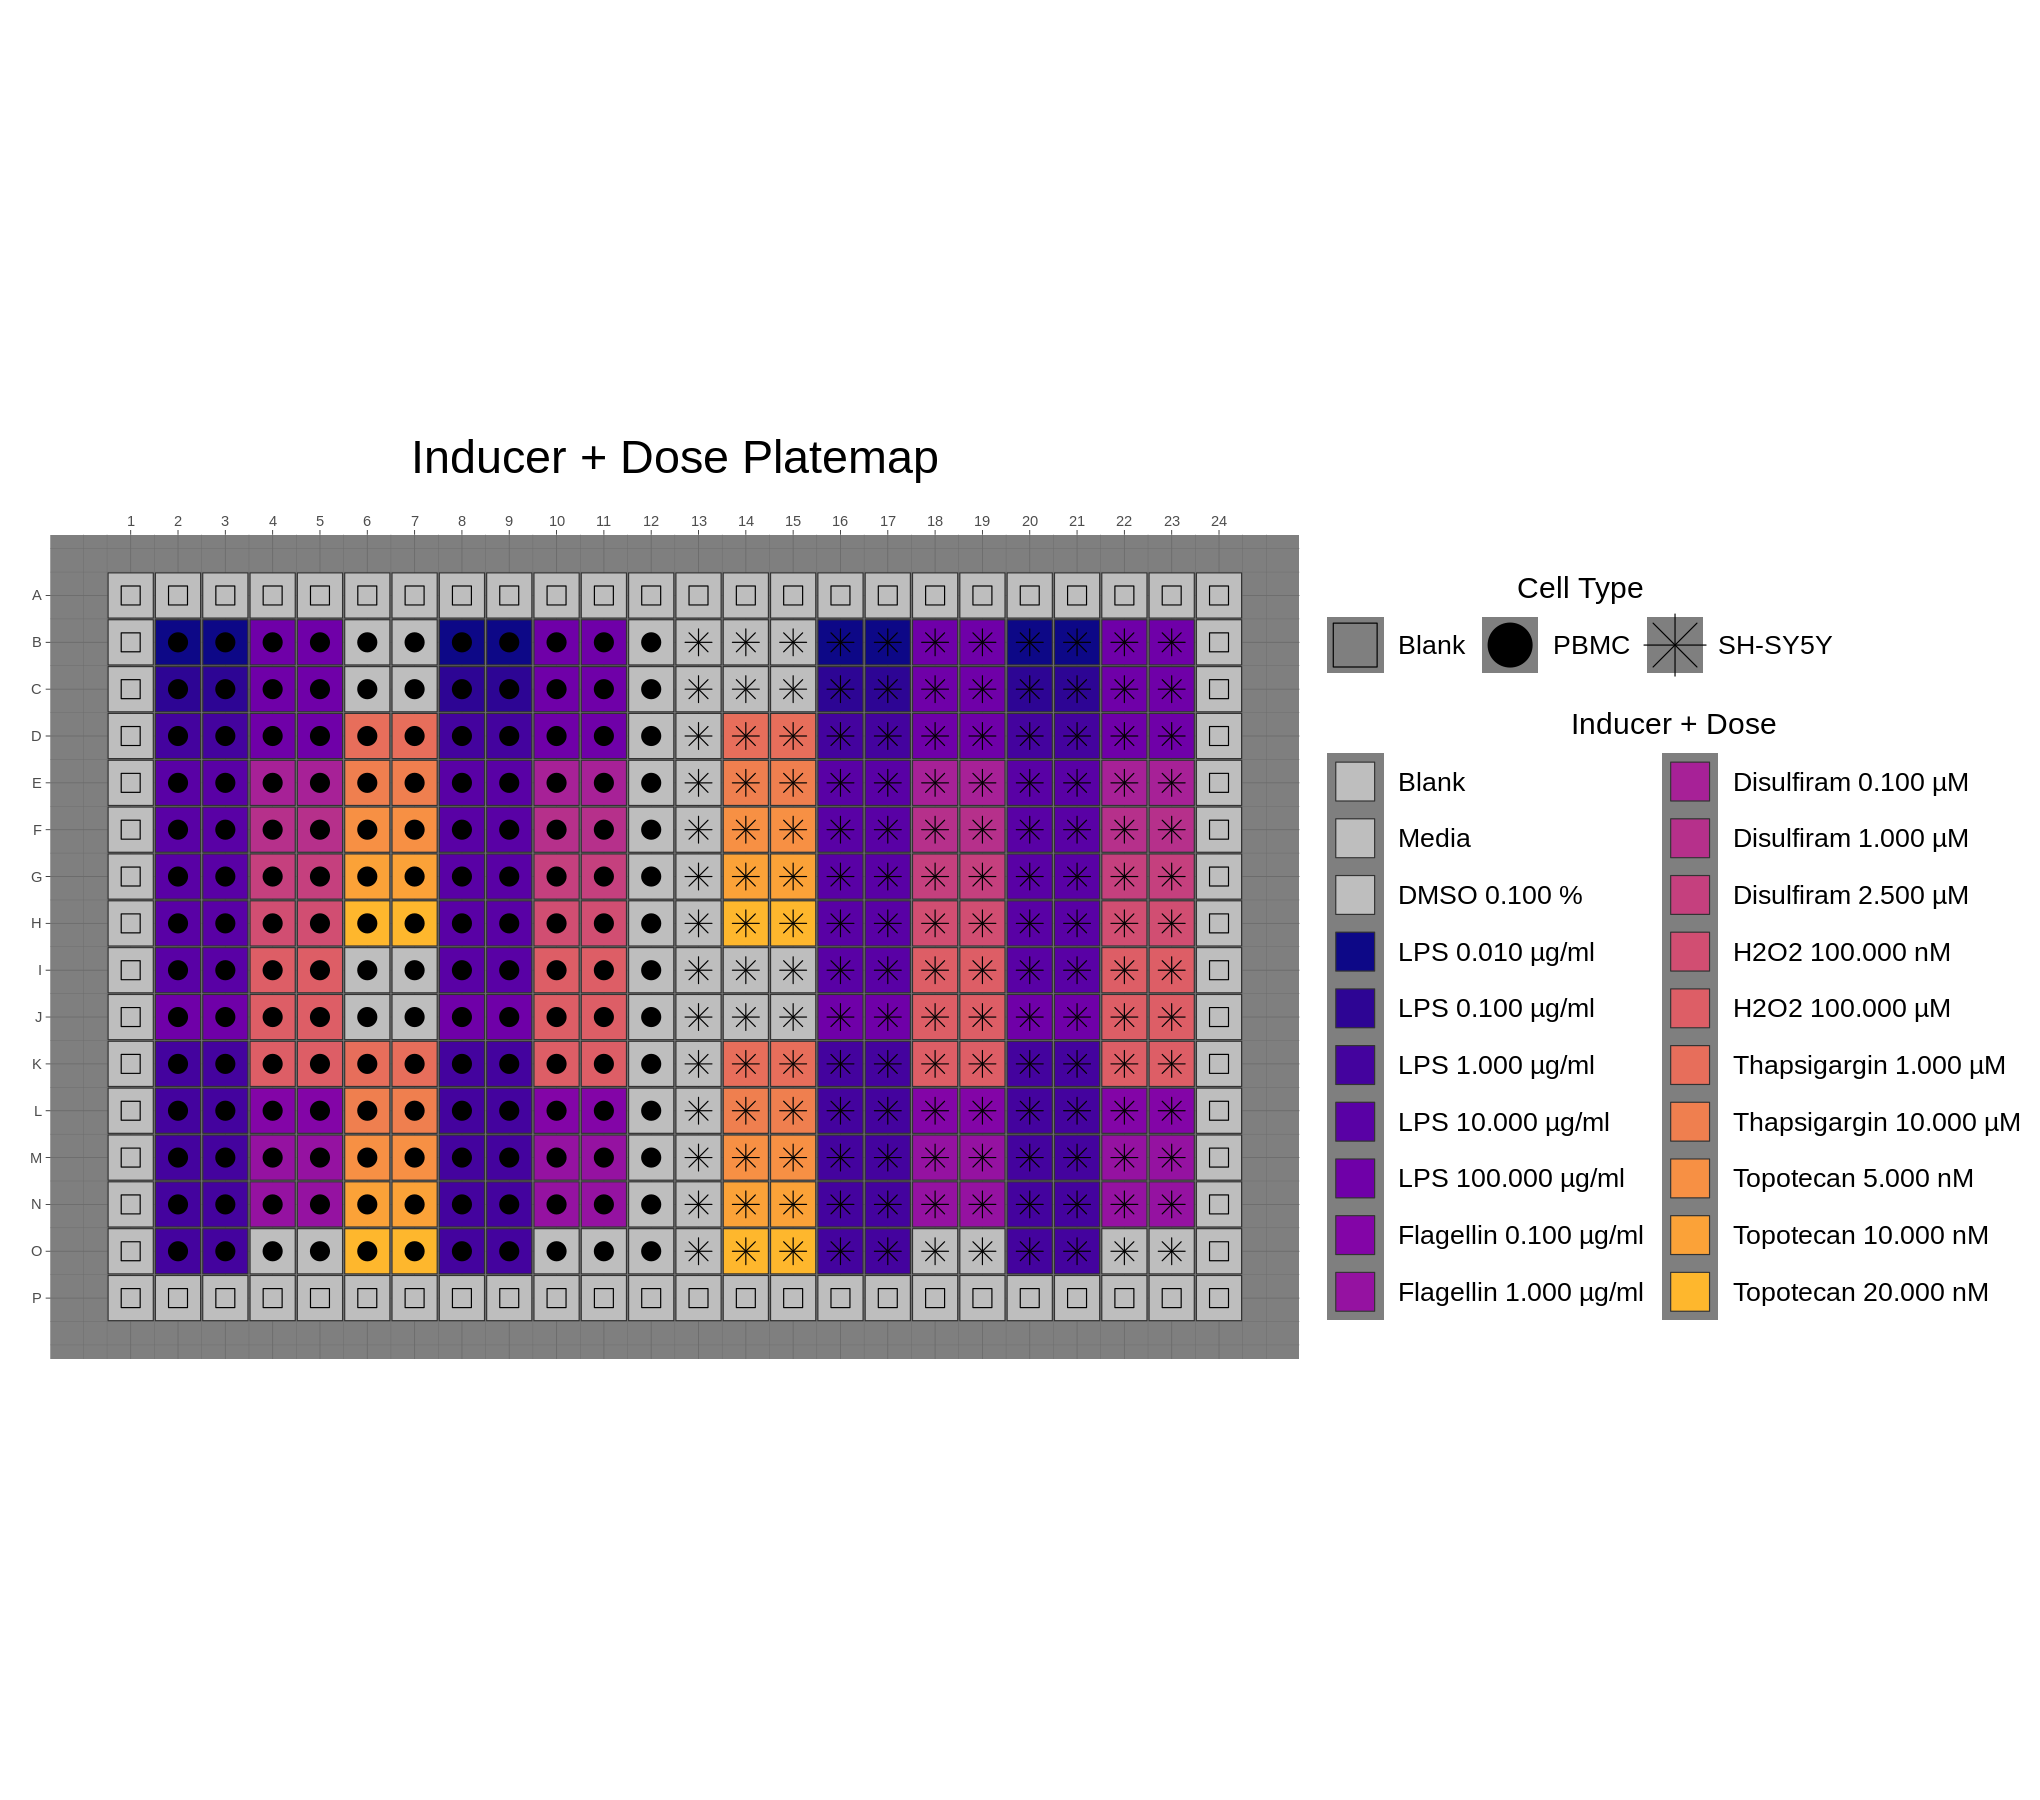

In [7]:
# define pallete
# viridis colors
viridis_pal_custom <- viridis::viridis_pal(option = 'C')(20)

width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
inducer_well_dose_platemap <- file.path(paste0(platemap_path,"inducer_well_dose_platemap.png"))
# if path does not exist, create it
platemap_plot_inducer_dose <- (
    raw_map(
        data = platemap_df$inducer1_conc,
        well = platemap_df$well_id,
        plate = 384,
        size = 14)
    + theme_dark() 
    # fill the color by dose
    + ggplot2::geom_point(
            aes(shape = platemap_df$cell_type),
            size = 5
            )
       

        + labs(fill = "Inducer + Dose", shape = "Cell Type")
        # remove shape legend from plot
        + guides(fill = guide_legend(override.aes = list(size = 12),ncol = 2))
        + guides(shape = guide_legend(override.aes = list(size = 12),nrow = 1))
        + theme(
            legend.title = element_text(size = 18,hjust = 0.5),
            legend.text = element_text(size = 16)
        )
        # make the blank well grey
        + scale_fill_manual(
            values = c(
                'Blank' = 'grey',
                'Media' = 'grey',
                'DMSO 0.100 %' = 'grey',
                'LPS 0.010 µg/ml' = viridis_pal_custom[1],
                'LPS 0.100 µg/ml' = viridis_pal_custom[2],
                'LPS 1.000 µg/ml' = viridis_pal_custom[3],
                'LPS 10.000 µg/ml' = viridis_pal_custom[4],
                'LPS 100.000 µg/ml' = viridis_pal_custom[5],
                'Flagellin 0.100 µg/ml' = viridis_pal_custom[6],
                'Flagellin 1.000 µg/ml' = viridis_pal_custom[7],
                'Disulfiram 0.100 µM' = viridis_pal_custom[8],
                'Disulfiram 1.000 µM' = viridis_pal_custom[9],
                'Disulfiram 2.500 µM' = viridis_pal_custom[10],
                'H2O2 100.000 nM' = viridis_pal_custom[11],
                'H2O2 100.000 µM' = viridis_pal_custom[12],
                'Thapsigargin 1.000 µM' = viridis_pal_custom[13],
                'Thapsigargin 10.000 µM' = viridis_pal_custom[14],
                'Topotecan 5.000 nM' = viridis_pal_custom[15],
                'Topotecan 10.000 nM' = viridis_pal_custom[16],
                'Topotecan 20.000 nM' = viridis_pal_custom[17]
            )
        )
        # change the shape of the blank well
        + scale_shape_manual(
            values = c(
                'Blank' = 0,
                'PBMC' = 19,
                'SH-SY5Y' = 8
            )
        )
        # make shape legend horizontal
        # title
    + ggtitle("Inducer + Dose Platemap")
    + theme(plot.title = element_text(size = 28, hjust = 0.5))
    
)
ggsave(inducer_well_dose_platemap, platemap_plot_inducer_dose, width=8, height=8, dpi=500)
platemap_plot_inducer_dose


In [8]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inhibitor[platemap_df$inhibitor == "Media ctr"] <- "Media"
platemap_df$inhibitor[platemap_df$inhibitor == " "] <- "Blank"

In [9]:
# create a new column that is the combination of inducer and inducer concentration
platemap_df$inhibitor_conc <- paste0(platemap_df$inhibitor, " ", platemap_df$inhibitor_concentration, " ",  platemap_df$inhibitor_concentration_unit)
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == " "] <- "Blank"


In [10]:
viridis_pal_custom <- viridis::viridis_pal(option = "C")(7)

In [11]:
# replace 'media ctr  µg/ml' with 'media ctr  ug/ml'
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "Media ctr NA "] <- "media ctr"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "Media NA "] <- "Media ctr"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == " "] <- "Blank"

platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == ""] <- "Blank"
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == '  '] <- "Blank"
platemap_df$cell_type[platemap_df$cell_type == ""] <- "Blank"
# replace  'DMSO 0.00025 %' with 'DMSO 0.025 %'
platemap_df$inhibitor_conc[platemap_df$inhibitor_conc == "DMSO 0.00025 %"] <- "DMSO 0.025 %"
unique(platemap_df$inhibitor_conc)
# make the inhibitor_conc a factor
platemap_df$inhibitor_conc <- factor(
    platemap_df$inhibitor_conc, 
    levels = c(
    'Blank',
    'Media  ',
    'DMSO 0.025 %',
    'DMSO 1 %',
    'Disulfiram 0.1 µM',
    'Disulfiram 1 µM',
    'Disulfiram 2.5 µM',
    'Z-VAD-FMK 30 µM',
    'Z-VAD-FMK 100 µM'
    )
)



[1] "Blank"             "DMSO 0.025 %"      "Disulfiram 0.1 µM"
[4] "Disulfiram 1 µM"   "Disulfiram 2.5 µM" "Z-VAD-FMK 100 µM" 
[7] "Media  "           "DMSO 1 %"          "Z-VAD-FMK 30 µM"

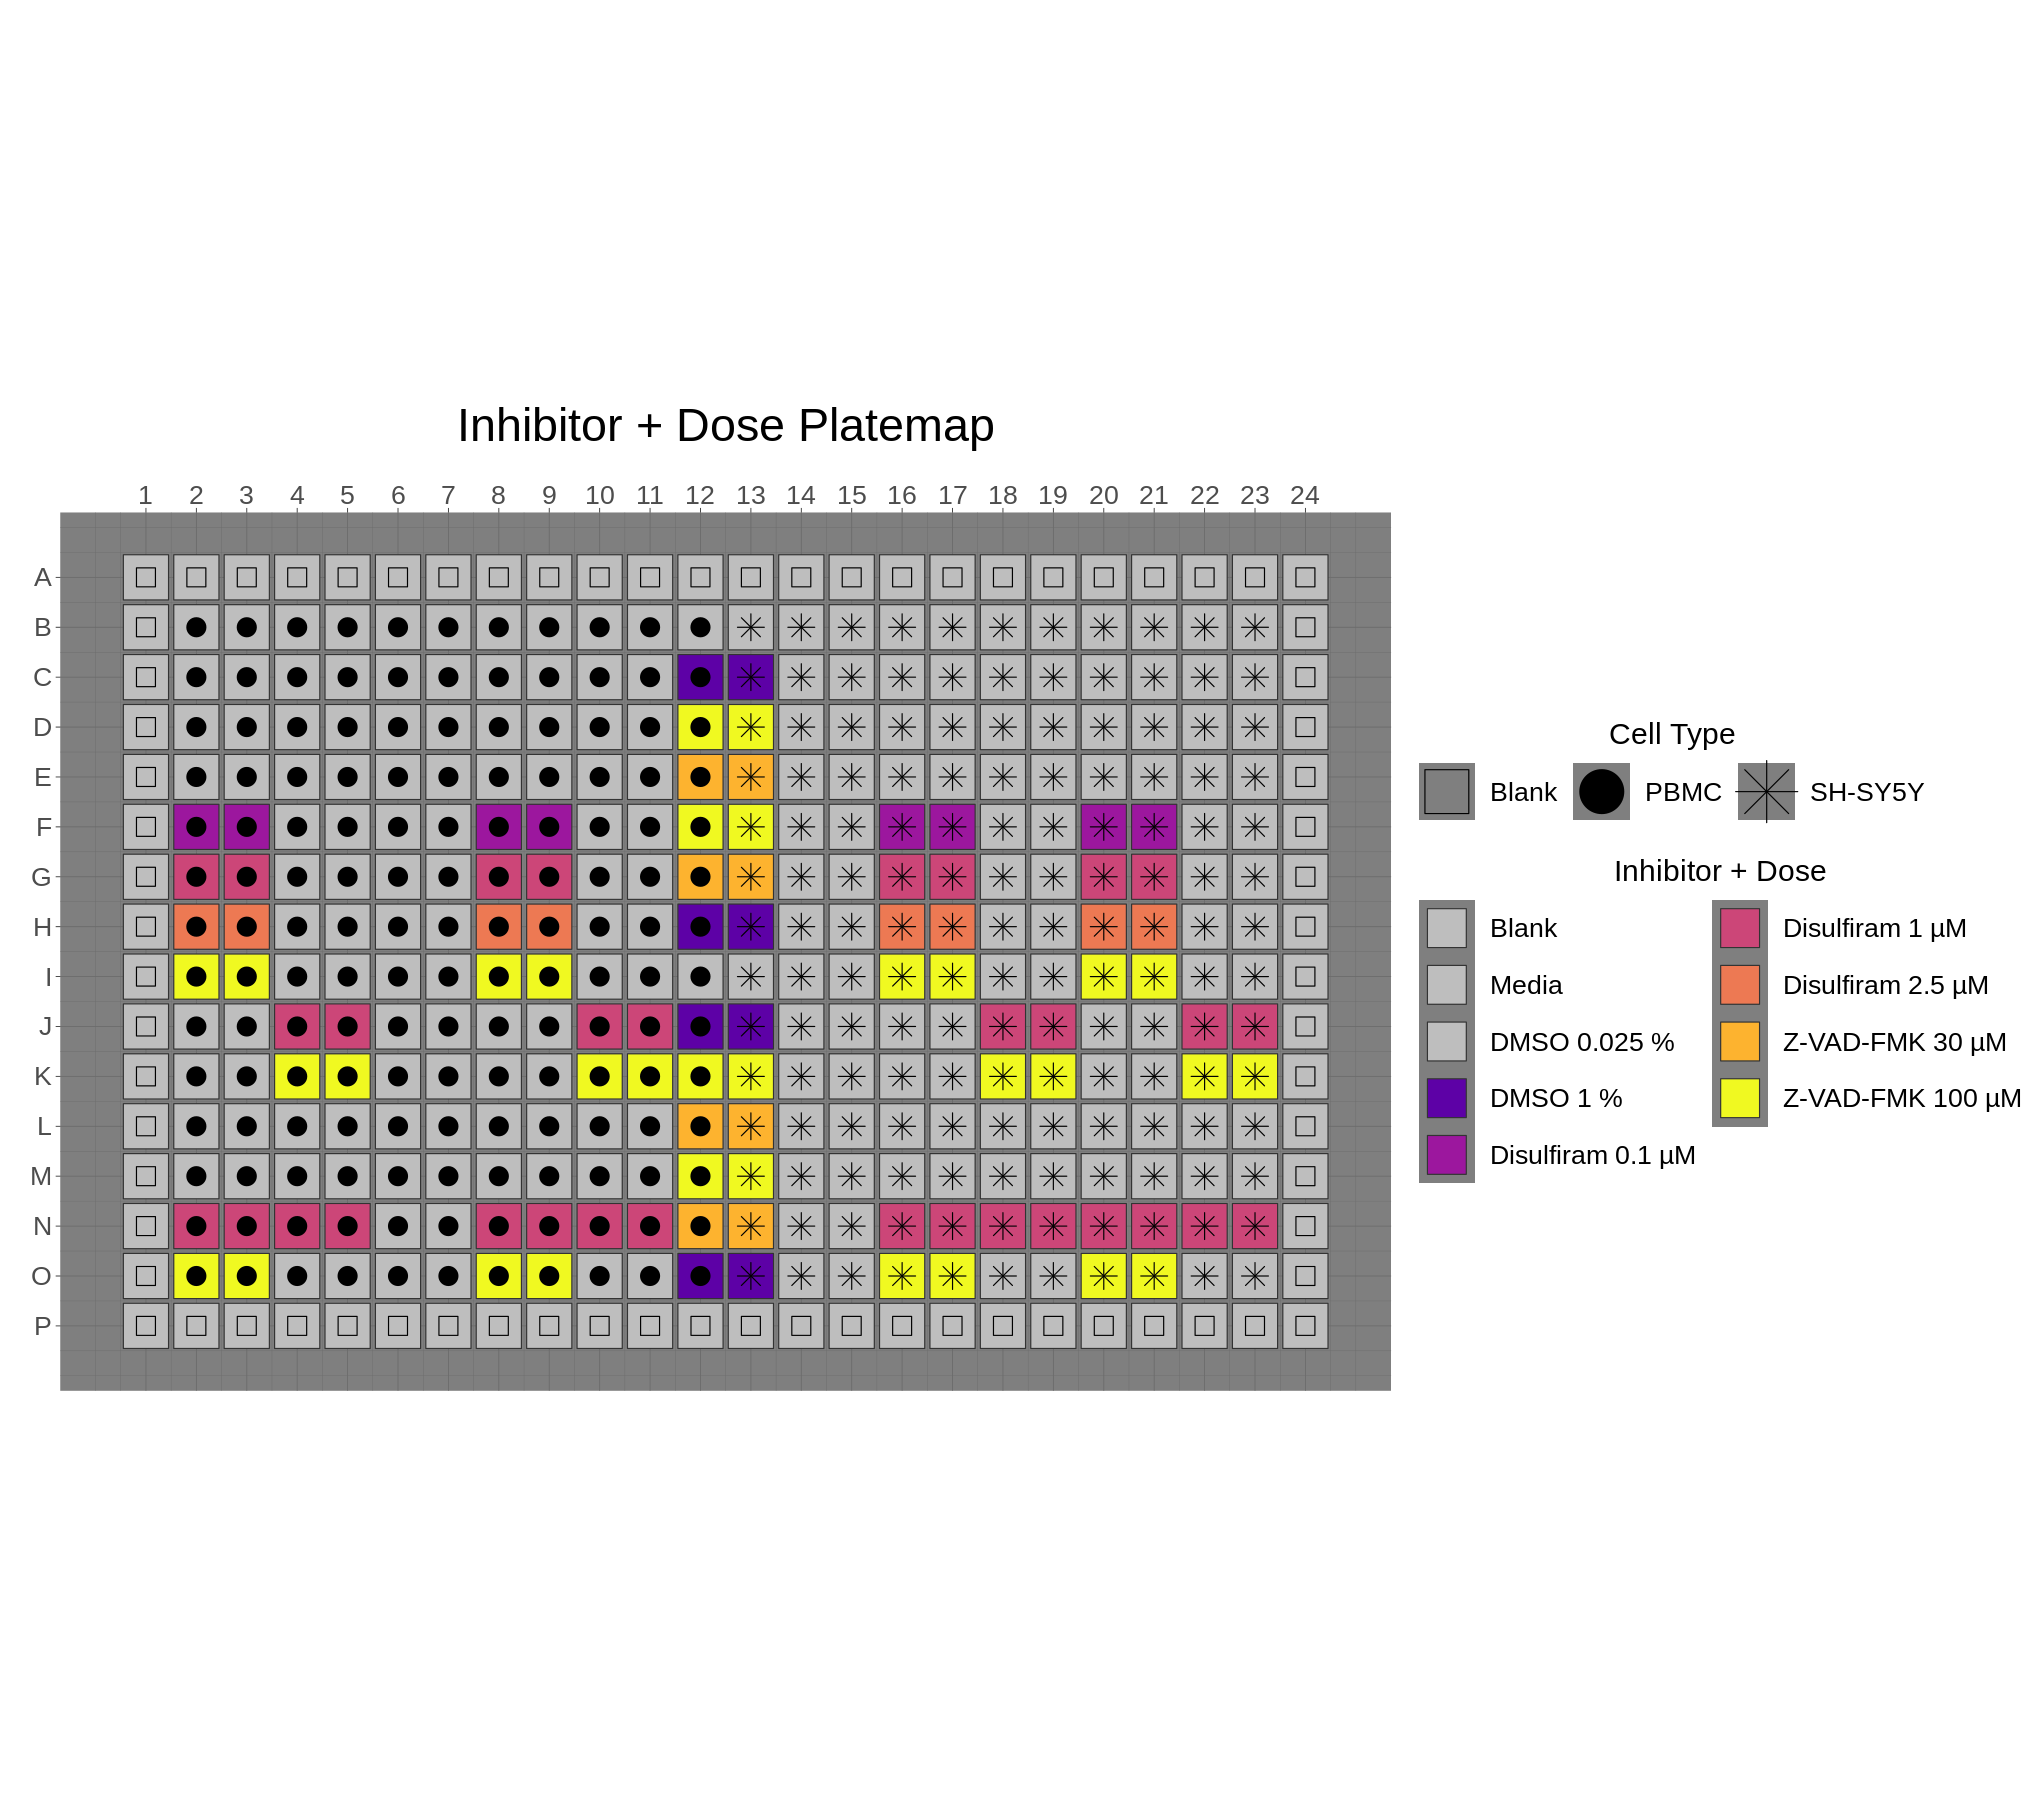

In [12]:
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
inhibtor_well_dose_platemap <- file.path(paste0(platemap_path,"inhibtor_well_dose_platemap.png"))
# if path does not exist, create it
platemap_plot_inhibitor_dose <- (
    raw_map(
        data = platemap_df$inhibitor_conc,
        well = platemap_df$well_id,
        plate = 384,
        size = 14)
    + theme_dark() 
    # fill the color by dose
    + ggplot2::geom_point(
        aes(shape = platemap_df$cell_type),
        size = 5
        )
        # change the size of the shapes in the legend and plot
    # 2 column legend
    + labs(fill = "Inhibitor + Dose", shape = "Cell Type")
    # change legend text size for fill
    
    + guides(shape = guide_legend(override.aes = list(size = 12), nrow = 1))
    + guides(fill = guide_legend(override.aes = list(size = 12),ncol = 2))
    + theme(
        legend.title = element_text(size = 18,hjust = 0.5),
        legend.text = element_text(size = 16),
    )
    # make the blank well grey
        + scale_fill_manual(
            values = c(
                'Blank' = 'grey',
                'Media  ' = 'grey',
                'DMSO 0.025 %' = 'grey',
                'DMSO 1 %' = viridis_pal_custom[2],
                'Disulfiram 0.1 µM' = viridis_pal_custom[3],
                'Disulfiram 1 µM' = viridis_pal_custom[4],
                'Disulfiram 2.5 µM' = viridis_pal_custom[5],
                'Z-VAD-FMK 30 µM' = viridis_pal_custom[6],
                'Z-VAD-FMK 100 µM' = viridis_pal_custom[7]
            )
        )
        # change the shape of the blank well
        + scale_shape_manual(
            values = c(
                'Blank' = 0,
                'PBMC' = 19,
                'SH-SY5Y' = 8
            )
        )
    # x axis ticks larger
    + theme(
        axis.text.x = element_text(size = 16),
        axis.text.y = element_text(size = 16)
    )
    # title
    + ggtitle("Inhibitor + Dose Platemap")
    + theme(plot.title = element_text(size = 28, hjust = 0.5))
    
)
ggsave(inhibtor_well_dose_platemap, platemap_plot_inhibitor_dose, width=8, height=8, dpi=500)
platemap_plot_inhibitor_dose 


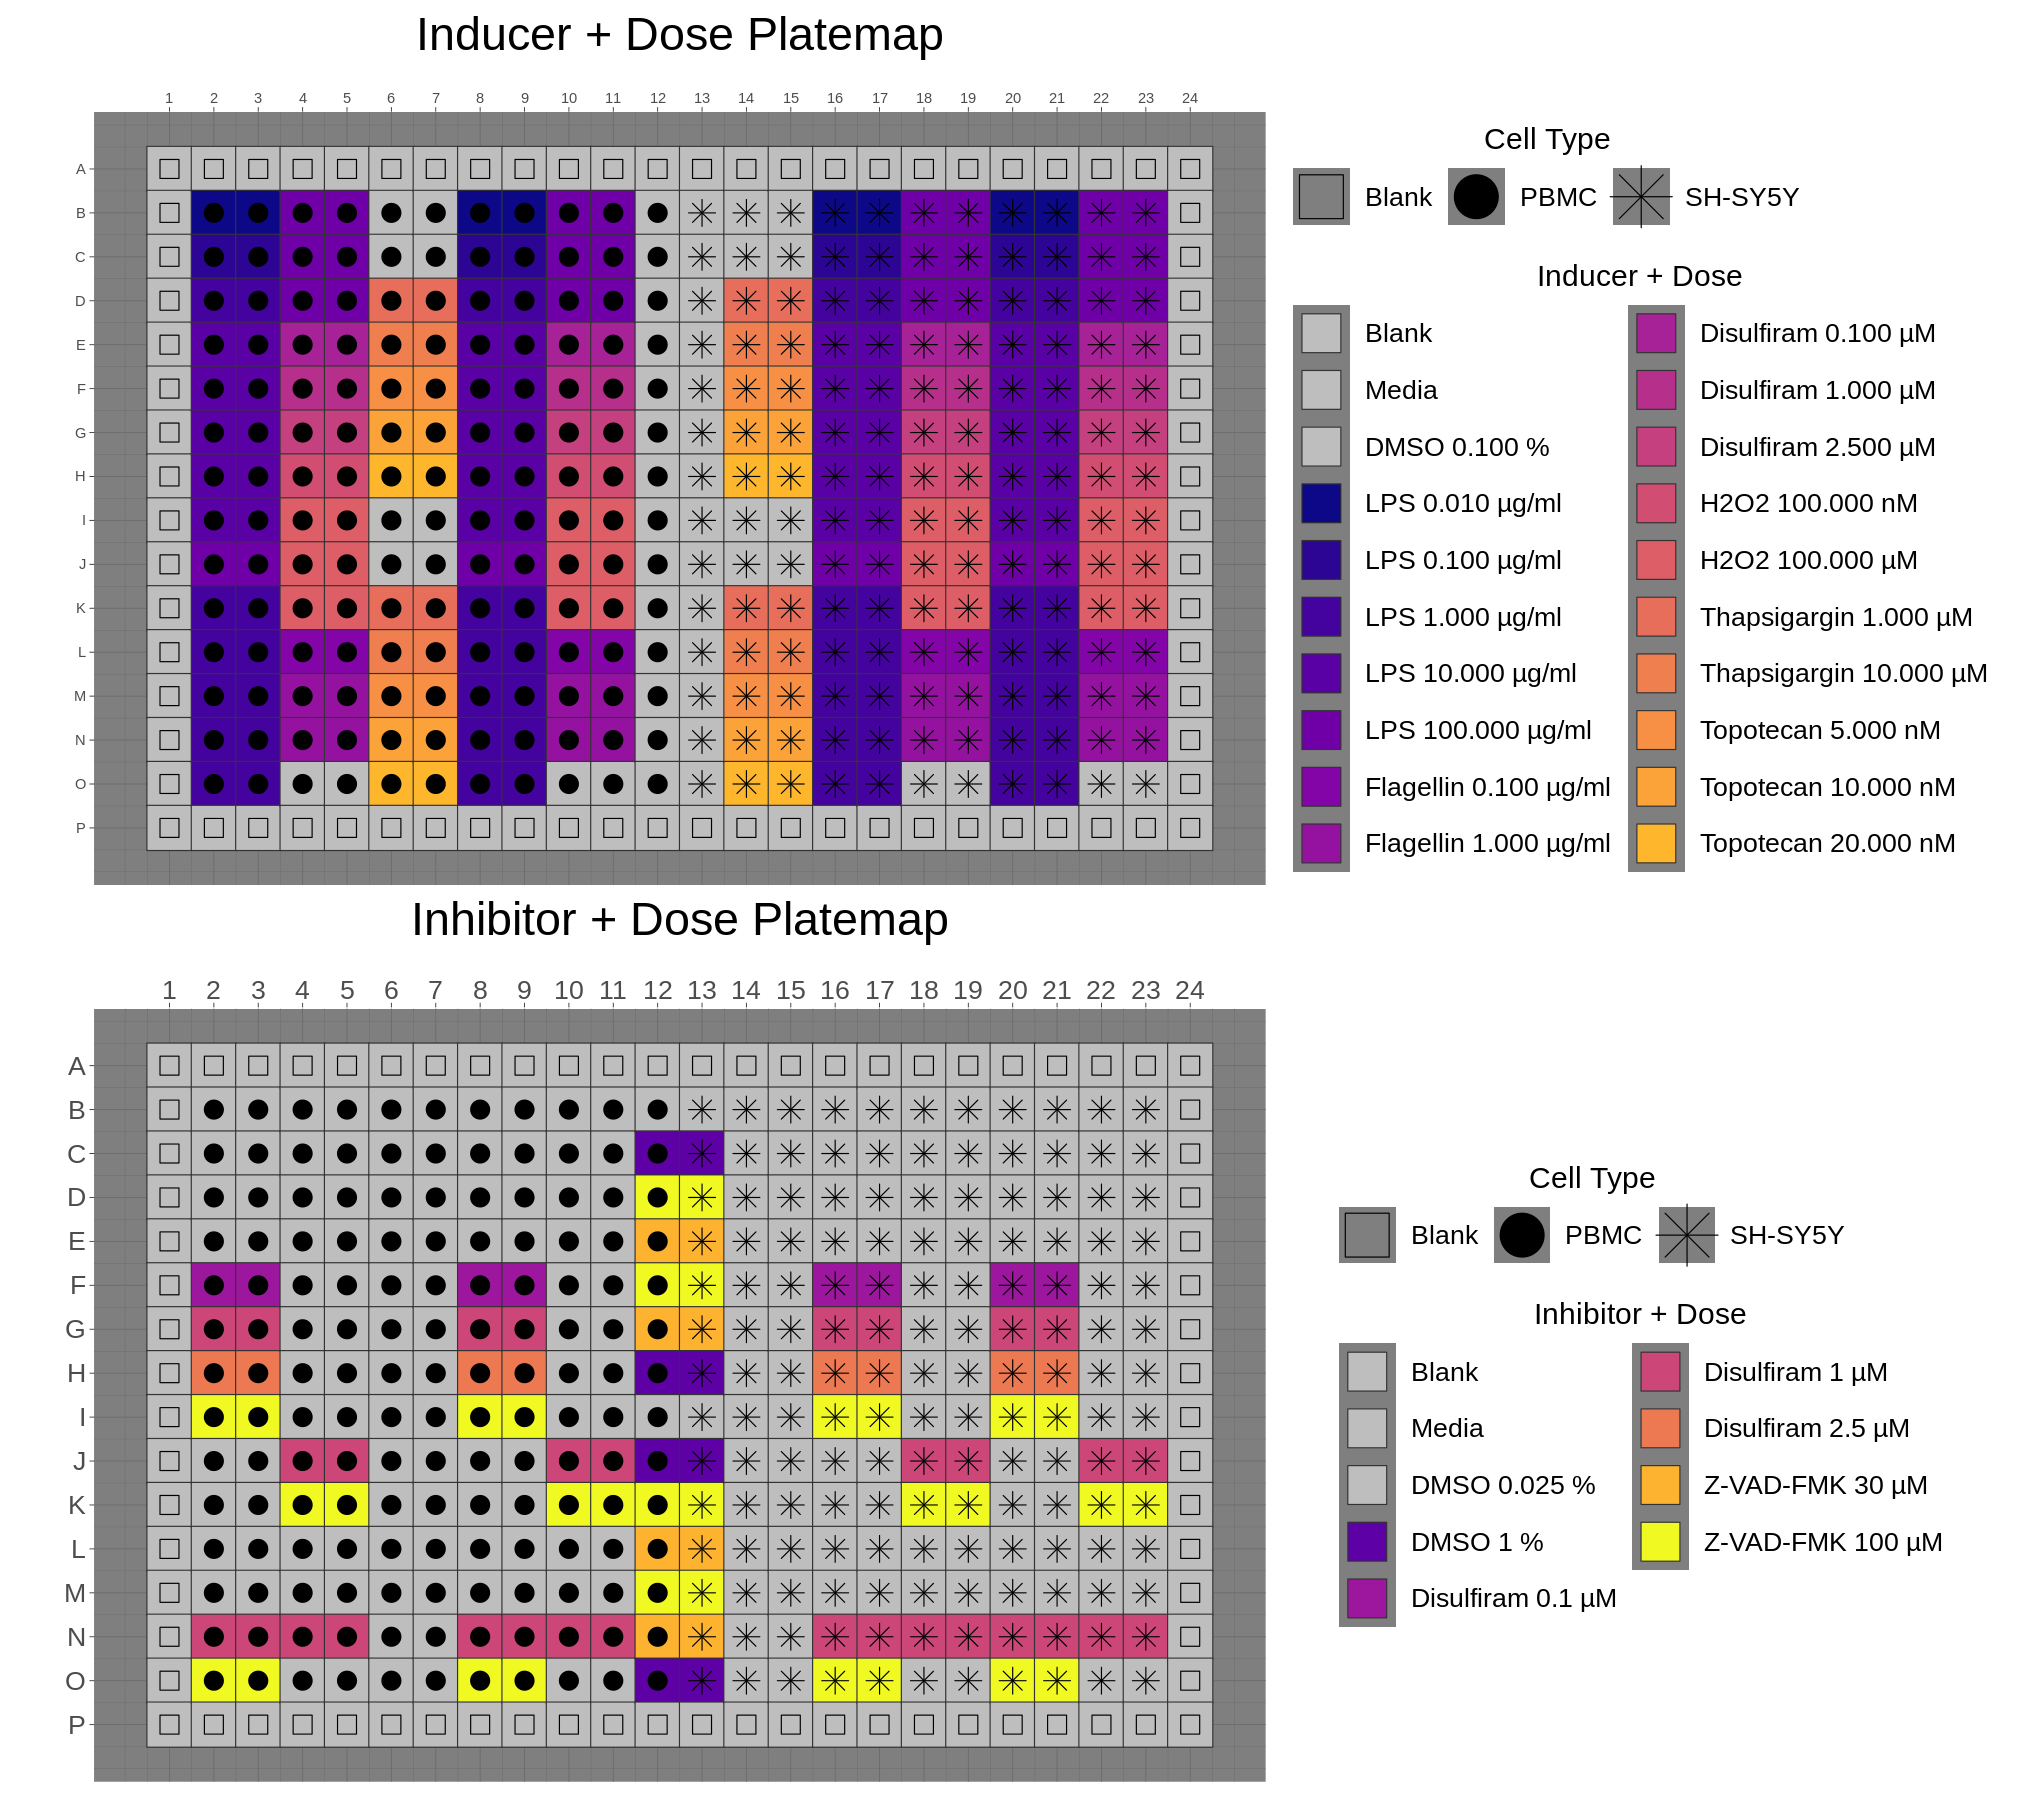

In [13]:
# pathwork for platemaps
width <- 17
height <- 15
options(repr.plot.width = width, repr.plot.height = height)

layout <- c(
    area(t=1, b=1, l=1, r=1),
    area(t=2, b=2, l=1, r=1)
)

patch_plot <- (
    platemap_plot_inducer_dose
    + platemap_plot_inhibitor_dose
    + plot_layout(design = layout)
)
patch_plot
# set save path for patchwork plot
patchwork_platemap_path <- file.path(paste0(platemap_path,"figureS2.png"))
ggsave(patchwork_platemap_path, patch_plot, width=17, height=17, dpi=600)